In [2]:
import numpy as np
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import resnet50

In [3]:
import wandb

In [4]:
with open('/root/.netrc', 'w', encoding='utf-8') as f:
    f.write('''machine api.wandb.ai
        login user
        password 22eff3c6a2aefa82e35e00f9c8e01b065c5e3ce0
    ''')

In [5]:
wandb.init(project = 'cycle-gan',entity="iuh", name = 'restnet')

wandb: Currently logged in as: nqh29092001 (iuh). Use `wandb login --relogin` to force relogin


In [7]:
from wandb.keras import WandbCallback


In [8]:
image_array = np.load('../input/product-250-amazon/image_array_250.npy')
label_array = np.load('../input/product-250-amazon/label_array_250.npy')

In [9]:
train_images, val_images, train_labels, val_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.3, random_state=42)
val_images,test_images, val_labels, test_labels=train_test_split(val_images, val_labels,
                                                                      test_size=0.33, random_state=42)

train_images, test_images, val_images = train_images / 255, test_images / 255,val_images / 255

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3498
Number of validation samples : 1005
Number of       test samples : 495


In [10]:
lr = 0.001
epoch = 20
batch_size = 16

In [11]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
with strategy.scope():    
    resnet_model = Sequential()
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                       input_shape=(224,224,3),
                       pooling='avg')
    for layer in pretrained_model.layers:
        layer.trainable=True

    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(20, activation='softmax'))
    resnet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
resnet_model.summary()

2022-12-05 15:47:58.393099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 15:47:58.494825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 15:47:58.495877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 15:47:58.498142: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 24,647,060
Trainable params: 24,593,940
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.001)

In [14]:
history = resnet_model.fit(train_images, train_labels, batch_size = batch_size , epochs = epoch, 
                    validation_data = (val_images,  val_labels),callbacks=[WandbCallback()])

2022-12-05 15:48:11.563940: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2106187776 exceeds 10% of free system memory.
2022-12-05 15:48:14.094697: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2106187776 exceeds 10% of free system memory.
2022-12-05 15:48:16.989966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 15:48:16.990372: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-12-05 15:48:16.991522: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-12-05 15:48:16.992831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 15:48:16.993364

Epoch 1/20


2022-12-05 15:48:26.362742: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


219/219 [==============================] - ETA: 0s - loss: 2.0570 - accuracy: 0.4079

2022-12-05 15:48:56.265525: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 605122560 exceeds 10% of free system memory.
2022-12-05 15:48:57.462103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 605122560 exceeds 10% of free system memory.


219/219 [==============================] - 41s 131ms/step - loss: 2.0570 - accuracy: 0.4079 - val_loss: 3.2925 - val_accuracy: 0.0517


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
219/219 [==============================] - 24s 112ms/step - loss: 0.9861 - accuracy: 0.7067 - val_loss: 3.3231 - val_accuracy: 0.1144
Epoch 3/20
219/219 [==============================] - 24s 112ms/step - loss: 0.4055 - accuracy: 0.8879 - val_loss: 2.7904 - val_accuracy: 0.2796
Epoch 4/20
219/219 [==============================] - 24s 110ms/step - loss: 0.1558 - accuracy: 0.9663 - val_loss: 2.9778 - val_accuracy: 0.4060
Epoch 5/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0947 - accuracy: 0.9797 - val_loss: 2.2789 - val_accuracy: 0.4846
Epoch 6/20
219/219 [==============================] - 24s 109ms/step - loss: 0.1124 - accuracy: 0.9714 - val_loss: 3.3080 - val_accuracy: 0.4418
Epoch 7/20
219/219 [==============================] - 24s 109ms/step - loss: 0.3264 - accuracy: 0.8937 - val_loss: 2.7796 - val_accuracy: 0.4090
Epoch 8/20
219/219 [==============================] - 24s 109ms/step - loss: 0.1809 - accuracy: 0.9508 - val_loss: 2.5431 - val_ac

In [9]:
print("Loss of the model is - " , resnet_model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , resnet_model.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-04 06:33:56.965979: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 298045440 exceeds 10% of free system memory.


16/16 [==============================] - 1s 75ms/step - loss: 3.0950 - accuracy: 0.4505
Loss of the model is -  3.0949838161468506
16/16 [==============================] - 1s 62ms/step - loss: 3.0950 - accuracy: 0.4505
Accuracy of the model is -  45.05050480365753 %


In [11]:
resnet_model.save('Resnet50.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


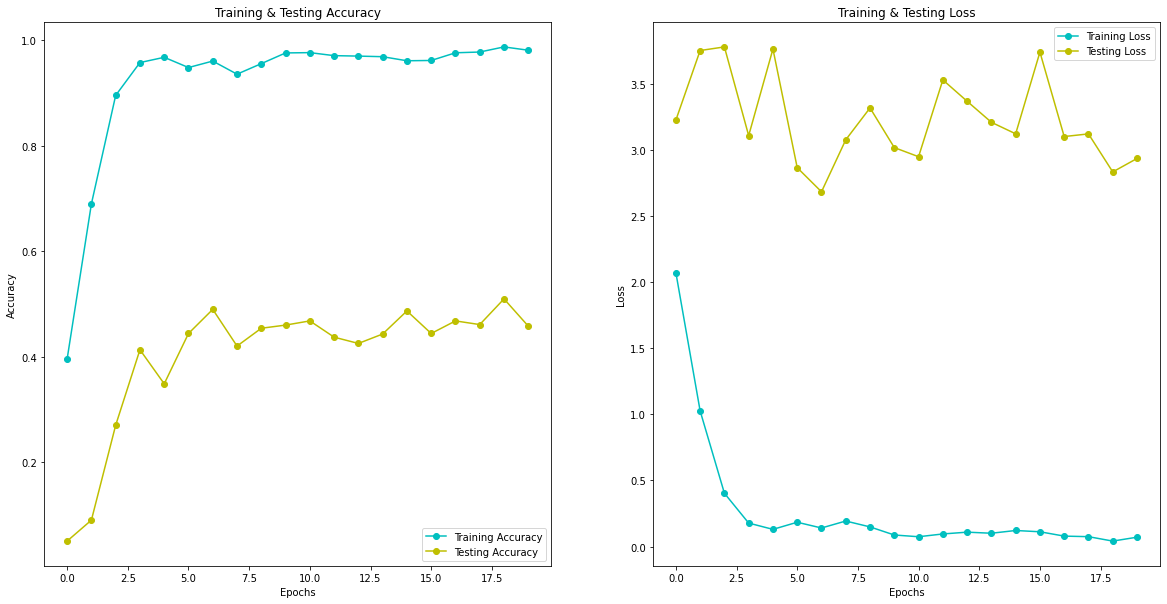

In [22]:
epochs = [i for i in range(epoch)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'co-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-', label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'c-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o', label= 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()